Ζαχαριουδάκη Αικατερίνη Μεθοδία

ΑΜ 1115201900060

In [1]:
import re
import random
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for downloading nltk data in Kaggle
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
import emoji
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import optuna
from gensim.models import KeyedVectors
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Load Data

In [2]:
# local input
# train_data = pd.read_csv('train_dataset.csv')
# val_data = pd.read_csv('val_dataset.csv')
# test_data = pd.read_csv('test_dataset.csv')

# kaggle input
train_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv')
val_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv')
test_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv')

## Text Preprocessing

In [ ]:
def preprocess_text(text):
    emoticons = {
        ':)': ' smile ',
        ':-)': ' smile ',
        ':(': ' sad ',
        ':-(': ' sad ',
        ':D': ' laugh ',
        ':-D': ' laugh ',
        ':P': ' playful ',
        ':-P': ' playful ',
        ';)': ' wink ',
        ';-)': ' wink ',
        ":'(": ' cry ',
        ':-/': ' skeptical ',
        ':/': ' skeptical ',
        ':|': ' neutral ',
        ':-|': ' neutral ',
        ':O': ' surprised ',
        ':-O': ' surprised ',
        ':*': ' kiss ',
        ':-*': ' kiss ',
        'xd': ' laugh ',
    }
    def replace_emoticons(text):
        for emoticon, replacement in emoticons.items():
            text = text.replace(emoticon, replacement)
        return text
    
    text = emoji.demojize(text)
    text = replace_emoticons(text)
    
    text = text.lower()

    # remove tags, urls, html entities, emails, time
    text,_ = re.subn(r'\B@\S+', ' user ', text)
    text,_ = re.subn(r'https?:\S+', ' link ', text)
    text,_ = re.subn(r'www.\S+', ' link ', text)
    text,_ = re.subn(r'&\w+;', '', text)
    text,_ = re.subn(r'\S+@\S+\.\S+', '', text)
    text,_ = re.subn(r'([0-1]?[0-9]|[2][0-3]):([0-5][0-9])0', ' time ', text)

    # remove contractions
    text,_ = re.subn(r'\'', '', text)

    # remove excess letters
    pattern = re.compile(r'(.)\1{2,}')
    text = pattern.sub(r'\1\1', text)

    # replace common abbreviations and slang
    text,_ = re.subn(r'\su\s', ' you ', text)
    text,_ = re.subn(r'\bwit\b', ' with ', text)
    text,_ = re.subn(r'\bb\b', ' be ', text)
    text,_ = re.subn(r'\bxo\b', ' kiss ', text)
    text,_ = re.subn(r'\bxx\b', ' kiss ', text)
    text,_ = re.subn(r'\bluv\b', ' love ', text)
    text,_ = re.subn(r'\bpl[sz]+\b', ' please ', text)
    text,_ = re.subn(r'\btho\b', ' though ', text)
    text,_ = re.subn(r'\bthx\b', ' thank ', text)
    text,_ = re.subn(r'\bsux\b', ' suck ', text)
    text,_ = re.subn(r'\bgr8\b', ' great ', text)
    text,_ = re.subn(r'\bb4\b', ' before ', text)
    text,_ = re.subn(r'\bh8\b', ' hate ', text)
    text,_ = re.subn(r'\bh8r\b', ' hater ', text)
    text,_ = re.subn(r'\bw8\b', ' wait ', text)
    text,_ = re.subn(r'\bstr8\b', ' straight ', text)
    text,_ = re.subn(r'\b2moro\b', ' tomorrow ', text)
    text,_ = re.subn(r'\b2day\b', ' today ', text)
    text,_ = re.subn(r'\b2night\b', ' tonight ', text)
    text,_ = re.subn(r'\b2nite\b', ' tonight ', text)
    text,_ = re.subn(r'\b4ever\b', ' forever ', text)
    text,_ = re.subn(r'\bcu\b', ' see you ', text)
    text,_ = re.subn(r'\bwkend\b', ' weekend ', text)
    text,_ = re.subn(r'\bda\b', ' the ', text)
    text,_ = re.subn(r'\bnd\b', ' and ', text)
    text,_ = re.subn(r'\bkewl\b', ' cool ', text)
    text,_ = re.subn(r'\bliek\b', ' like ', text)
    text,_ = re.subn(r'\bteh\b', ' the ', text)
    text,_ = re.subn(r'\bwen\b', ' when ', text)
    text,_ = re.subn(r'\bwat\b', ' what ', text)
    text,_ = re.subn(r'\bwut\b', ' what ', text)
    text,_ = re.subn(r'\bbrb\b', ' be right back ', text)
    text,_ = re.subn(r'\bbbl\b', ' be back later ', text)
    text,_ = re.subn(r'\bbf\b', ' boyfriend ', text)
    text,_ = re.subn(r'\bgf\b', ' girlfriend ', text)
    text,_ = re.subn(r'\bily\b', ' i love you ', text)
    text,_ = re.subn(r'\bidk\b', ' i dont know ', text)
    text,_ = re.subn(r'\bimo\b', ' in my opinion ', text)
    text,_ = re.subn(r'\bb/c\b', ' because ', text)
    text,_ = re.subn(r'\bbc\b', ' because ', text)
    text,_ = re.subn(r'\babt\b', ' about ', text)
    text,_ = re.subn(r'\bbtw\b', ' by the way ', text)
    text,_ = re.subn(r'\bftw\b', ' for the win ', text)
    text,_ = re.subn(r'\btbh\b', ' to be honest ', text)
    text,_ = re.subn(r'\b(a*ha+h[ha]*)\b', ' laugh ', text)
    text,_ = re.subn(r'\b(o?l+o+l+[ol]*)\b', ' lol ', text)
    text,_ = re.subn(r'\b(?=lmao)\S*(\S+)(?<=\blmao)\1*\b', ' lol ', text)
    text,_ = re.subn(r'\b(?=omg)\S*(\S+)(?<=\bomg)\1*\b', ' omg ', text)

    # remove numbers
    text,_ = re.subn(r'\b\d+\b', '', text)

    # remove special characters
    text,_ = re.subn(r'[^\w\s]',' ', text)
    text,_ = re.subn(r'\s+', ' ', text)
    
    # lemmatize
    text = WordNetLemmatizer().lemmatize(text)

    # split into words
    text = text.split()

    return text

train_data['Text'] = train_data['Text'].apply(preprocess_text)
val_data['Text'] = val_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

## Vectorization

In [4]:
# Load GloVe model locally
# glove_file = 'glove.twitter.27B.200d.txt'
glove_file = '/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt'
w2v_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# Alternatively, you can use the gensim downloader to load a pre-trained model
# w2v_model = api.load("glove-twitter-200")

def get_tweet_vector(df):
    vectors = []
    for i in range(len(df)):
        vectors.append(w2v_model.get_mean_vector(df['Text'][i]))
    return vectors

train_data['Vector'] = get_tweet_vector(train_data)
val_data['Vector'] = get_tweet_vector(val_data)
test_data['Vector'] = get_tweet_vector(test_data)

## Data to Torch Datasets

In [5]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.x = data
        self.len = len(self.x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.x[index].to(torch.float32)

In [6]:
X_train = torch.tensor(np.array([x for x in train_data['Vector']]), dtype=torch.float32)
X_val = torch.tensor(np.array([x for x in val_data['Vector']]), dtype=torch.float32)
X_test = torch.tensor(np.array([x for x in test_data['Vector']]), dtype=torch.float32)

y_train = torch.tensor(train_data['Label'].values, dtype=torch.long)
y_val = torch.tensor(val_data['Label'].values, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = MyDataset(X_test)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## Reproducibility

In [7]:
def torch_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Base Model

We define the training and evaluation functions below. Training runs for number of epochs times, each time going through the training data. The evaluation function makes the predictions for the validation set and then calculates the accuracy, f1 score, precision, recall and the confusion matrix.

In [8]:
def evaluation(dataloader, model, loss_fn, device, printing=False, plotting=False):
    model.eval()
    losses = []
    predictions = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = loss_fn(pred, y.unsqueeze(1).float())
            losses.append(loss.item())
            pred = torch.sigmoid(pred).squeeze(1)
            probs.extend(pred.cpu().numpy())
            predictions.extend(torch.round(pred).int().cpu().numpy())
            labels.extend(y.cpu().numpy())

    mean_loss = np.mean(losses)
    f1 = f1_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    confmatrix = confusion_matrix(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)

    if printing:
        print('\n~~~~~Evaluation~~~~~\n')
        print(f'Mean loss: {mean_loss}')
        print(f'Accuracy: {accuracy}')
        print(f'F1-score: {f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'Confusion Matrix: \n{confmatrix}')

    if plotting:
        fpr, tpr, thresholds = roc_curve(labels, probs) 
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    return f1, accuracy, mean_loss

In [9]:
def training(epochs, optimizer, dataloader, loss_fn, model, device, printing=True):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for (x, y) in dataloader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = loss_fn(pred, y.unsqueeze(1).float())
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(np.mean(losses))
        _, _, val_loss_epoch = evaluation(val_dataloader, model, loss_fn, device, printing=False)
        val_loss.append(val_loss_epoch)

        if printing:
            print(f'Epoch {epoch:<2} : Loss = {np.mean(losses)}')
       
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()
    plt.show()

    return model

We implement a simple model as the baseline model

In [10]:
class BaseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(200, 1)
        )

    def forward(self, x):
        out = self.linear_stack(x)
        return out

Epoch 0  : Loss = 0.6828109922080204
Epoch 1  : Loss = 0.6650722030935616
Epoch 2  : Loss = 0.6506239007259237
Epoch 3  : Loss = 0.638513812525519
Epoch 4  : Loss = 0.6281314812857529


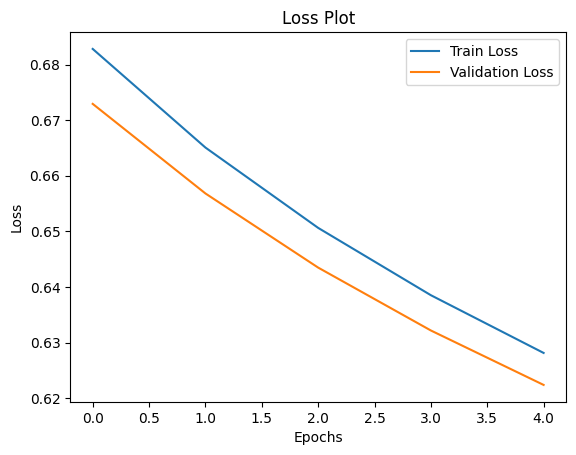


~~~~~Evaluation~~~~~

Mean loss: 0.6223784003938947
Accuracy: 0.7047362958769695
F1-score: 0.690608007909046
Precision: 0.7253517470536317
Recall: 0.659040520779282
Confusion Matrix: 
[[15907  5290]
 [ 7228 13971]]


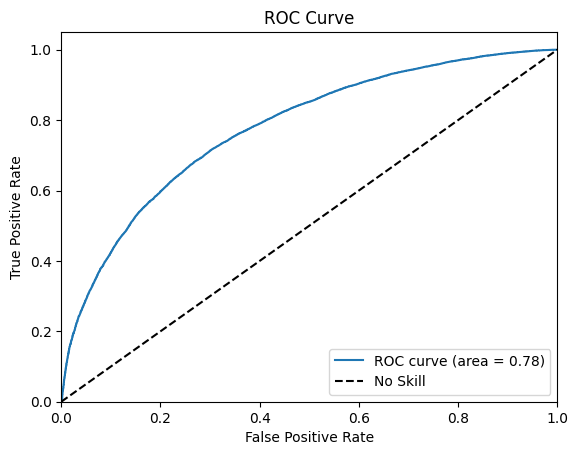

In [11]:
device = 'cuda'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_seed(13)

learning_rate = 0.001
epochs = 5
loss_fn = nn.BCEWithLogitsLoss()

model = BaseNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = training(epochs, optimizer, train_dataloader, loss_fn, model, device, val_dataloader)

_ = evaluation(val_dataloader, model, loss_fn, device, True, True)

## Final Model

We redefine the training function so that it returns the the model that has the best f1 score in its epoch. This way we stop the model before overfitting.
We also define the testing function which predicts the labels for the test set and it saves them to the submission.csv

In [12]:
def training(epochs, optimizer, dataloader, loss_fn, model, device, val_dataloader, printing=True, trial=None, plotting=False):
    best_model = None
    best_f1 = -1
    best_epoch = 0
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for (x, y) in dataloader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = loss_fn(pred, y.unsqueeze(1).float())
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(np.mean(losses))
        f1, acc, val_loss_epoch = evaluation(val_dataloader, model, loss_fn, device, printing=False)
        val_loss.append(val_loss_epoch)

        if f1 > best_f1:
            best_f1 = f1
            best_epoch = epoch
            best_model = model
        if printing:
            print(f'Epoch {epoch:<2} : Loss = {np.mean(losses)}')

        if trial is not None:
            trial.report(acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    if printing:
        print(f'Best epoch: {best_epoch} - best f1: {best_f1}')

    if plotting:
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Plot')
        plt.legend()
        plt.show()

    return best_model

In [13]:
def testing(dataloader, model, device, df):
    model.eval()

    predictions = []

    with torch.no_grad():
      for x in dataloader:
        x = x.to(device)
        pred = model(x)
        pred = torch.sigmoid(pred).squeeze(1)
        predictions.extend(torch.round(pred).int().cpu().numpy())
        
    output = pd.DataFrame(df['ID'])
    output['Label'] = predictions
    output.to_csv('submission.csv', index=False)

Below we implement the best model we found through hyper-parameter tuning (the code is at the bottom of the notebook).

In [14]:
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.linear_stack(x)
        return out

Epoch 0  : Loss = 0.5810320646598421
Epoch 1  : Loss = 0.4942335800877933
Epoch 2  : Loss = 0.48373098291199784
Epoch 3  : Loss = 0.4781980004803888
Epoch 4  : Loss = 0.4753981493670365
Epoch 5  : Loss = 0.4710823422875898
Epoch 6  : Loss = 0.46841624543584626
Epoch 7  : Loss = 0.46765163951906663
Epoch 8  : Loss = 0.4642426055053185
Epoch 9  : Loss = 0.4626853285164669
Epoch 10 : Loss = 0.46113267150418513
Epoch 11 : Loss = 0.45883644634279713
Epoch 12 : Loss = 0.45663284433299095
Epoch 13 : Loss = 0.45522336096599186
Epoch 14 : Loss = 0.45309553310788914
Epoch 15 : Loss = 0.45161302994037494
Epoch 16 : Loss = 0.4508477728942345
Epoch 17 : Loss = 0.4497717456570987
Epoch 18 : Loss = 0.44791653176833846
Epoch 19 : Loss = 0.4457391360710407
Epoch 20 : Loss = 0.44497807210889356
Epoch 21 : Loss = 0.4438978160249776
Epoch 22 : Loss = 0.4433798097330948
Epoch 23 : Loss = 0.44168078180017145
Epoch 24 : Loss = 0.439293935381133
Epoch 25 : Loss = 0.4386477564943248
Epoch 26 : Loss = 0.4370997

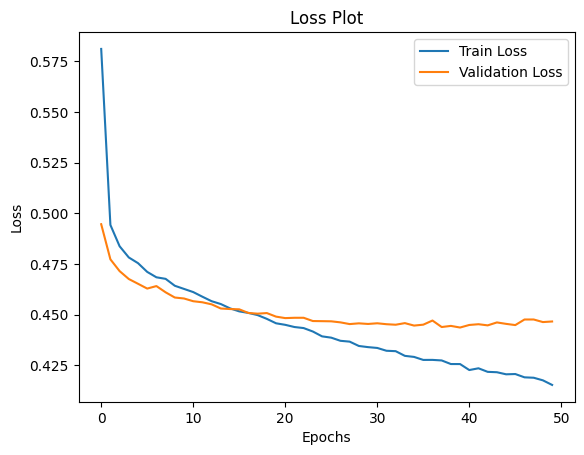


~~~~~Evaluation~~~~~

Mean loss: 0.44662981799670626
Accuracy: 0.7867959241437872
F1-score: 0.7826275160522329
Precision: 0.7982731554160125
Recall: 0.7675833765743667
Confusion Matrix: 
[[17085  4112]
 [ 4927 16272]]


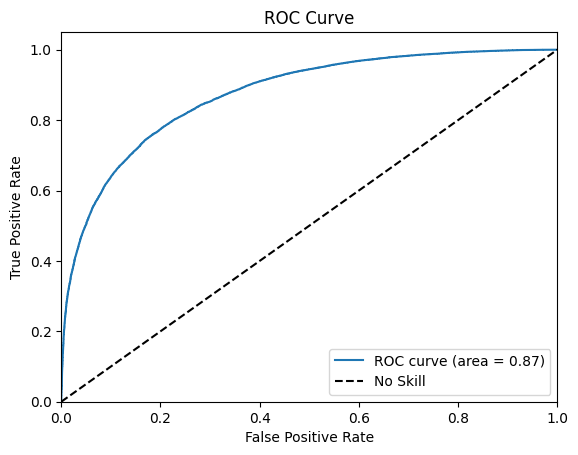

In [15]:
device = 'cuda'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_seed(13)

learning_rate = 0.001
epochs = 50
loss_fn = nn.BCEWithLogitsLoss()

model = FFNN().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model = training(epochs, optimizer, train_dataloader, loss_fn, model, device, val_dataloader, printing=True, plotting=True)

_ = evaluation(val_dataloader, model, loss_fn, device, True, True)
testing(test_dataloader, model, device, test_data)

## Hyper-parameter tuning

Below is the code for the hyper-parameter tuning using the optuna framework. We define a new model, that has an input of a linear stack, as we are tuning the architecture of the model as well as the optimizer.

In [ ]:
# class OFNN(nn.Module):
#     def __init__(self, stack):
#         super().__init__()
#         self.linear_stack = stack

#     def forward(self, x):
#         out = self.linear_stack(x)
#         return out

# warnings.filterwarnings("ignore", category=UserWarning)

# def create_model(trial):
#     n_layers = trial.suggest_int('n_layers', 1, 2)
#     # activation = trial.suggest_categorical('activation', [nn.ReLU, nn.LeakyReLU, nn.Sigmoid, nn.Tanh, nn.SiLU])
#     activation = nn.ReLU
#     layers = []
#     div = trial.suggest_categorical('div', [2, 4])
#     dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.1)
#     batchn = trial.suggest_categorical('batchnorm', [True, False])
#     in_size = 200
#     out_size = trial.suggest_categorical('h1', [64, 128, 256])
#     for i in range(n_layers):
#         layers.append(nn.Linear(in_size, out_size))
#         layers.append(activation())
#         layers.append(nn.Dropout(dropout))
#         if batchn:
#             layers.append(nn.BatchNorm1d(out_size))
#         in_size = out_size
#         out_size = int(in_size/div)
#     layers.append(nn.Linear(in_size, 1))

#     return nn.Sequential(*layers)

# def objective(trial):
#     device = 'cuda'
#     torch_seed(13)
#     epochs = 40
#     loss_fn = nn.BCEWithLogitsLoss()

#     model = OFNN(create_model(trial)).to(device)
    
#     # opt = trial.suggest_categorical('optimizer', [torch.optim.Adagrad, torch.optim.Adam, torch.optim.AdamW, torch.optim.Adamax, torch.optim.NAdam, torch.optim.RAdam])
#     opt = trial.suggest_categorical('optimizer', [torch.optim.AdamW, torch.optim.Adamax, torch.optim.NAdam, torch.optim.RAdam])
#     optimizer = opt(model.parameters(), lr=0.001)

#     bestmodel = training(epochs, optimizer, train_dataloader, loss_fn, model, device, val_dataloader, False, trial)
#     _, acc = evaluation(val_dataloader, bestmodel, loss_fn, device, False)
    
#     return acc

# pruner = optuna.pruners.MedianPruner(n_startup_trials=50, n_warmup_steps=10, n_min_trials=40)
# sampler = optuna.samplers.TPESampler(multivariate=True, seed=13)
# study = optuna.create_study(direction='maximize', pruner=pruner, sampler=sampler)

# study.optimize(objective, n_trials=300, show_progress_bar=True, gc_after_trial=True)

# print('Best accuracy: ', study.best_trial.value)
# print('Best trial: ', study.best_trial.params)